In [1]:
import numpy as np
import scvi 
import torch
import pandas as pd
import torch.distributions as dist
import scanpy as sc
from scCFM.models.base.vae import VAE, AE
from scCFM.models.base.geometric_vae import GeometricNBAE,GeometricNBVAE
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from scvi.distributions import NegativeBinomial
from tqdm import tqdm
import seaborn as sns

import scipy as sp
import  matplotlib.pyplot as plt

from typing import Optional

import torch
from torch.distributions import kl_divergence

from stochman.manifold import Manifold
from stochman.curves import BasicCurve, CubicSpline

from scCFM.models.manifold.geodesic import sc_geodesic_minimizing_energy
from scCFM.models.utils import get_distribution
from scCFM.models.manifold.utils import nb_kl

# Geodesic distance

In [2]:
def compute_geodesic_dist(manifold, c):
    # Compute the curve and length
    alpha = torch.linspace(0, 1, 100)  # Space of times selected
    traj = c(alpha)  # Computation of the curve at the given times (spline)
    return manifold.curve_length(traj)  # Calculation of the length 

In [3]:
class scStatisticalManifold(Manifold):
    def __init__(self, model, is_latent=True):
        # The VAE model 
        self.model = model 
        self.is_latent = is_latent  # Whether the manifold is a latent manifold
        
    def curve_energy(self, curve: torch.Tensor):
        """
        Given a curve of length L, measure the energy of given the KL divergence between subsequent points.
        """
        if len(curve.shape) == 2:
            curve = curve.unsqueeze(0)
        dt = (curve[:, :-1] - curve[:, 1:]).pow(2).sum(dim=-1).sqrt().squeeze(1)  # b
        kl = self._decode_and_kl(curve)
        return torch.sum(kl.view(kl.shape[0], -1), dim=1) * (2 * (dt ** -1))

    def curve_length(self, curve: torch.Tensor):
        """
        Given a curve of length L, measure the length of given the KL divergence between subsequent points.
        """
        if len(curve.shape) == 2:
            curve = curve.unsqueeze(0)
        kl = self._decode_and_kl(curve)
        return torch.sqrt(2 * torch.sum(kl.view(kl.shape[0], -1), dim=1))

    def connecting_geodesic(self, 
                            p0, 
                            p1, 
                            init_curve: Optional[BasicCurve] = None, 
                            max_iter=100, 
                            eval_grid=100, 
                            lr=1e-4, 
                            minimize_energy=False, 
                            return_losses=True):
        """
        Parameterize a spline as the shortest connecting curve in terms of length (or energy)
        """
        # Decouple curve and library size
        curve = CubicSpline(p0, p1)
        
        # Train the geodesic spline 
        losses = sc_geodesic_minimizing_energy(curve, 
                                                self, 
                                                max_iter=max_iter, 
                                                eval_grid=eval_grid,
                                                lr=lr, 
                                                minimize_energy=minimize_energy, 
                                                return_losses=return_losses)
        return curve, losses

    def metric(self, z, decoder_outputs, return_fisher=False):    
        """
        The metric is the pullback metric
        """
        # Compute the value of the Fisher matrix
        if self.model.likelihood == "nb":
            nb_fisher = self.model.theta.unsqueeze(0) / \
                (decoder_outputs["mu"] * (self.model.theta.unsqueeze(0) + decoder_outputs["mu"]))  # B x D
        else:
            raise NotImplementedError

        if return_fisher: 
            return nb_fisher
        
        # Use the canonical basis vectors to select separate columns of the decoder (speed reasons)
        basis =  torch.eye(z.shape[1])
        basis = basis.unsqueeze(0).expand(z.shape[0], z.shape[1], z.shape[1])  # B x d x d
        
        # Compute the statistical manifold metric tensor 
        jac = []
        for i in range(z.shape[1]):
            _, jac_partial = torch.func.jvp(self.model.decode,
                                            (z,), 
                                            (basis[:, :, i],))  # B x D
            jac.append(jac_partial)

        jac = torch.stack(jac, dim=-1)  # B x D x d
        return torch.einsum("bij,bik->bjk", jac, jac * nb_fisher.unsqueeze(-1))
    
    def _decode_and_kl(self, curve):
        """
        Perform decoding and compute the KL (or other notion of metrics) between successive steps.
        """
        if not self.is_latent:
            decoder_outputs1 = {"mu": curve[:, :-1, :]}
            decoder_outputs2 =  {"mu": curve[:, 1:, :]}
            dist1 = get_distribution(decoder_outputs1, 
                                     self.model.theta, 
                                     likelihood = "nb")
            dist2 = get_distribution(decoder_outputs2, 
                                     self.model.theta, 
                                     likelihood = "nb")
            kl = nb_kl(dist1, dist2)  
        else:
            decoder_outputs1 = self.model.decode(curve[:, :-1, :])
            decoder_outputs2 = self.model.decode(curve[:, 1:, :])
    
            dist1 = get_distribution(self.model._preprocess_decoder_output(decoder_outputs1), 
                                     self.model.theta, 
                                     likelihood = self.model.likelihood)
            dist2 = get_distribution(self.model._preprocess_decoder_output(decoder_outputs2), 
                                     self.model.theta, 
                                     likelihood = self.model.likelihood)
            kl = nb_kl(dist1, dist2)  
        return kl

In [4]:
# Set seed for reproducibility
torch.manual_seed(42)

# Parameters
num_genes = 10  # Number of genes
num_cells = 1000  # Number of cells
num_cell_types = 3  # Number of cell types

dist_means = [dist.Normal(torch.zeros(num_genes)+1, torch.ones(num_genes)),
              dist.Normal(torch.zeros(num_genes), torch.ones(num_genes)),
              dist.Normal(torch.zeros(num_genes)-1, torch.ones(num_genes))]

In [5]:
# dist_means = [dist.Normal(torch.zeros(num_genes)+1, torch.ones(num_genes)),
#               dist.Normal(torch.zeros(num_genes), torch.ones(num_genes)),
#               dist.Normal(torch.zeros(num_genes)-1, torch.ones(num_genes))]

In [6]:
# Generate inverse dispersion parameters (theta)
# Assume inverse dispersions are sampled from a gamma distribution
inverse_dispersion = torch.abs(torch.distributions.Gamma(2.0, 1.0).sample((num_genes,)))

# Generate size factors for each cell
size_factors = torch.exp(torch.distributions.LogNormal(0, 0.1).sample((num_cells,)))

# Assign cells to cell types (assuming balanced classes)
cell_type_indices = torch.randint(0, num_cell_types, (num_cells,))

In [7]:
# Initialize the counts matrix
counts = torch.zeros((num_cells, num_genes))
means = torch.zeros((num_cells, num_genes))

# Simulate counts for each cell
for i in range(num_cells):
    cell_type = cell_type_indices[i]
    mean = dist_means[cell_type].sample()
    # mu = size_factors[i] * torch.exp(mean)
    mu = torch.exp(mean)
    theta = inverse_dispersion

    means[i, :] = mu
    counts[i, :] = NegativeBinomial(mu=mu, theta=theta).sample()

# Show the first few simulated counts
print("Simulated Counts Matrix (first 5 cells, all 10 genes):")
print(counts[:5, :])  # Show first 5 cells and all 10 genes

Simulated Counts Matrix (first 5 cells, all 10 genes):
tensor([[ 0.,  0.,  0.,  0., 95.,  0.,  0.,  0.,  6.,  5.],
        [ 0.,  1.,  0.,  0.,  1.,  2.,  7.,  2.,  0.,  0.],
        [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.],
        [ 1.,  2.,  2.,  1.,  5.,  1.,  4.,  0.,  1.,  3.],
        [ 0.,  3.,  5.,  2.,  0.,  2.,  9.,  0.,  0., 28.]])


# Scanpy visualization

In [8]:
adata = sc.AnnData(X=counts.numpy().copy(), 
                  obs=pd.DataFrame({"cell_type": cell_type_indices.numpy()}))
adata.obs["cell_type"]=adata.obs["cell_type"].astype("category")
adata.layers["X_counts"] = adata.X.copy()

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


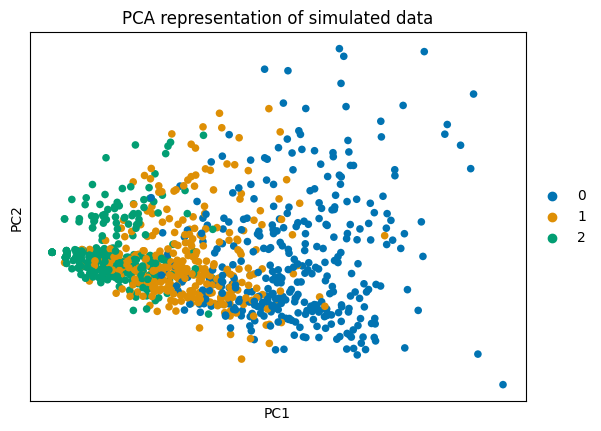

In [10]:
coloblind_palette = sns.color_palette("colorblind")
sc.pl.pca(adata, color="cell_type", palette=coloblind_palette, save="sim_repr.svg", title="PCA representation of simulated data")
# plt.savefig('sim_repr.svg', format='svg')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


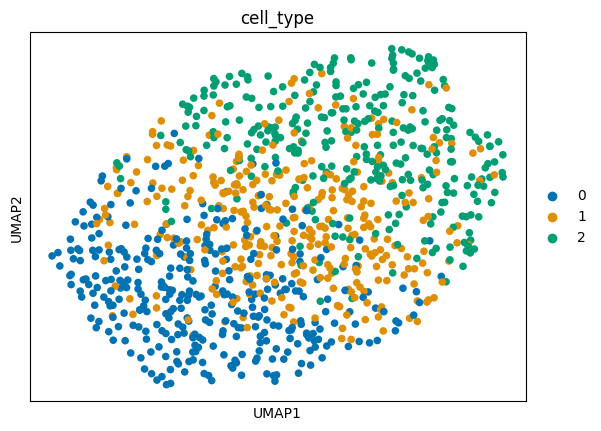

In [11]:
sc.pl.umap(adata, color="cell_type")

# Initialize FlatVI

In [12]:
class SingleCellDataset(Dataset):
    def __init__(self, counts):
        self.counts = counts

    def __len__(self):
        return len(self.counts)

    def __getitem__(self, idx):
        return {"X": self.counts[idx]}

# Create an instance of the custom dataset
dataset = SingleCellDataset(counts)

# Create a DataLoader to iterate over the dataset
batch_size = 32  # You can choose an appropriate batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Get models 

In [13]:
logger = WandbLogger(project="REBUTTAL_flatvi", offline= True,
                        id=None, # pass correct id to resume experiment!
                        log_model= False, # upload lightning ckpts
                        prefix= "", # a string to put at the beginning of metric keys
                        group= "",
                        tags= [],
                        job_type= "") 

In [14]:
vae_kwargs = dict(in_dim=10,
                    hidden_dims=[5, 2],
                    batch_norm=False,
                    dropout=False,
                    dropout_p=False,
                    n_epochs_anneal_kl=500,
                    kl_warmup_fraction=2,
                    kl_weight=None, 
                    likelihood="nb", 
                    learning_rate=0.001, 
                    model_library_size=False)

model_vae = VAE(**vae_kwargs) 


trainer_vae = Trainer(max_epochs=100,
           logger=logger)
             
# Fit the model 
trainer_vae.fit(model=model_vae, 
            train_dataloaders=dataloader, 
            val_dataloaders=dataloader)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id 7b363q36.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:258: Found unsupported keys in the lr scheduler dict: {'min_lr', 'threshold'}. HINT: remove them from the output of `configure_optimizers`.

  | Name           | Type   | Params | Mode 
--------------------------------------------------
0 | encoder_layers | MLP    | 55     | train
1 | decoder_layers | MLP    | 15     | train
2 | decoder_mu_lib | Linear | 60     | train
3 | mu_logvar      | Linear | 24     | train
  | other params   | n/a    | 10     | n/a  
--------------------------------------------------
164       Trainable params
0         Non-trainable params
164       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/icb/alessandro.palma/minic

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [15]:
model_flatvi = GeometricNBVAE(l2=True,
                        interpolate_z=False,
                        eta_interp=0,
                        start_jac_after=0,
                        use_c=False,
                        compute_metrics_every=1,
                        vae_kwargs=vae_kwargs, 
                        detach_theta=False,
                        fl_weight=10,
                        trainable_c=False,
                        anneal_fl_weight=False, 
                        max_fl_weight=False,
                        n_epochs_anneal_fl=None, 
                        fl_anneal_fraction=None)


trainer_flatvi = Trainer(max_epochs=100,
                            logger=logger)
             
# Fit the model 
trainer_flatvi.fit(model=model_flatvi, 
                    train_dataloaders=dataloader, 
                    val_dataloaders=dataloader)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory ./REBUTTAL_flatvi/7b363q36/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params | Mode 
--------------------------------------------------
0 | encoder_layers | MLP    | 55     | train
1 | decoder_layers | MLP    | 15     | train
2 | decoder_mu_lib | Linear | 60     | train
3 | mu_logvar   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [16]:
latents_vae = []
rec_vae = []
lab_vae = []
nll_vae = []

latents_flatvi = []
rec_flatvi = []
lab_flatvi = []
nll_flatvi = []

with torch.no_grad():
    for i, obs in enumerate(counts):
        X = obs.unsqueeze(0)

        latent_vae = model_vae.encode(X)["z"]
        z_rec_vae = model_vae.sample_decoder(latent_vae, library_size=X.sum(1))

        latent_flatvi = model_flatvi.encode(X)["z"]
        z_rec_flatvi = model_flatvi.sample_decoder(latent_flatvi, library_size=X.sum(1))

        
        rec_vae.append(z_rec_vae)
        latents_vae.append(latent_vae)
        rec_flatvi.append(z_rec_flatvi)
        latents_flatvi.append(latent_flatvi)
        lab_vae.append(cell_type_indices[i])
        lab_flatvi.append(cell_type_indices[i])

# Downstream

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


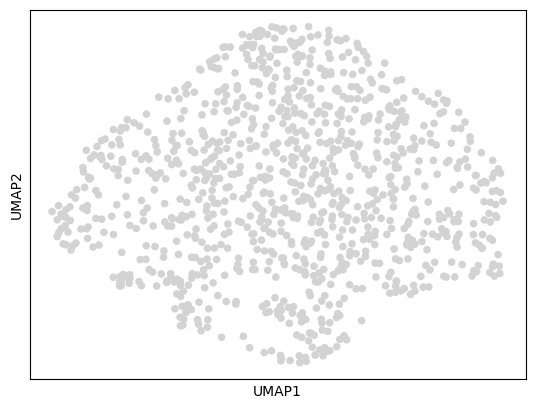

In [17]:
rec_vae = torch.cat(rec_vae, dim=0)
latents_vae = torch.cat(latents_vae, dim=0)

adata_vae = sc.AnnData(X=rec_vae.numpy())
sc.tl.pca(adata_vae)
sc.pp.neighbors(adata_vae)
sc.tl.umap(adata_vae)
sc.pl.umap(adata_vae)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


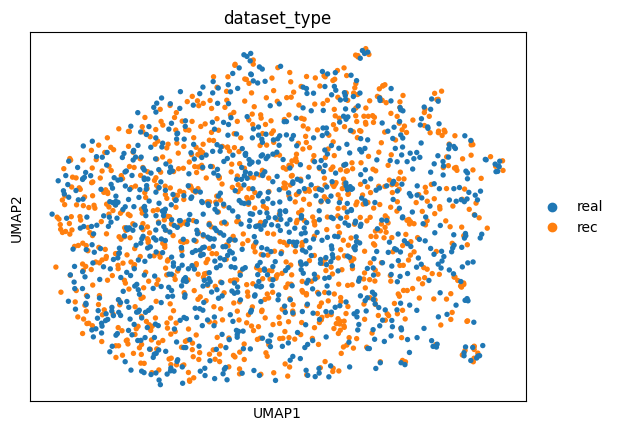

In [18]:
merged_vae = torch.cat([rec_vae, counts], dim=0)

adata_vae_merged = sc.AnnData(X=merged_vae.numpy().copy(), 
                  obs=pd.DataFrame({"dataset_type": ["rec" for _ in range(len(rec_vae))] + ["real" for _ in range(len(counts))]}))
sc.pp.log1p(adata_vae_merged)
sc.tl.pca(adata_vae_merged)
sc.pp.neighbors(adata_vae_merged)
sc.tl.umap(adata_vae_merged)
sc.pl.umap(adata_vae_merged, color="dataset_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


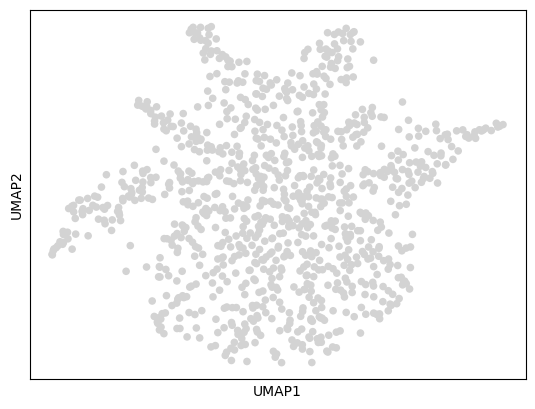

In [19]:
rec_flatvi = torch.cat(rec_flatvi, dim=0)
latents_flatvi = torch.cat(latents_flatvi, dim=0)

adata_flatvi = sc.AnnData(X=rec_flatvi.numpy())
sc.tl.pca(adata_flatvi)
sc.pp.neighbors(adata_flatvi)
sc.tl.umap(adata_flatvi)
sc.pl.umap(adata_flatvi)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


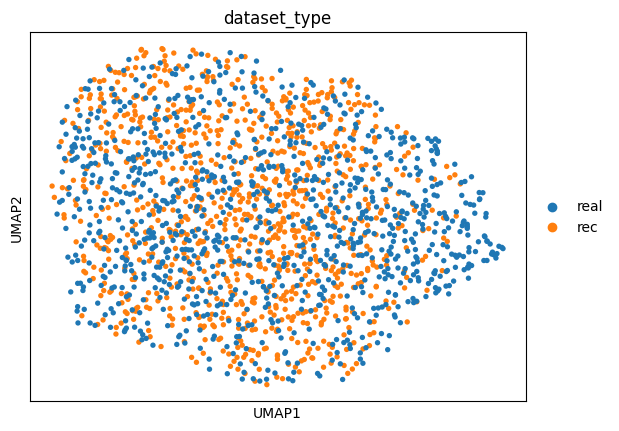

In [20]:
merged_flatvi = torch.cat([rec_flatvi, counts], dim=0)

adata_flatvi_merged = sc.AnnData(X=merged_flatvi.numpy().copy(), 
                  obs=pd.DataFrame({"dataset_type": ["rec" for _ in range(len(rec_flatvi))] + ["real" for _ in range(len(counts))]}))
sc.pp.log1p(adata_flatvi_merged)
sc.tl.pca(adata_flatvi_merged)
sc.pp.neighbors(adata_flatvi_merged)
sc.tl.umap(adata_flatvi_merged)
sc.pl.umap(adata_flatvi_merged, color="dataset_type")

# Compute geodesics with stochman

In [38]:
manifold_vae = scStatisticalManifold(model_vae, is_latent=True)
manifold_flatvi = scStatisticalManifold(model_flatvi, is_latent=True)

In [39]:
# dists_geodesic_latent_vae = []
# dists_latent_latent_vae = []
# dists_geodesic_latent_flatvi = []
# dists_latent_latent_flatvi = []

# np.random.seed(1)
# for _ in tqdm(range(1000)): 
#     # Get random indices
#     i = np.random.choice(range(1000))
#     j = np.random.choice(range(1000))
    
#     c_vae = manifold_vae.connecting_geodesic(latents_vae[i], latents_vae[j], minimize_energy=False)[0]
#     c_flatvi = manifold_flatvi.connecting_geodesic(latents_flatvi[i], latents_flatvi[j], minimize_energy=False)[0]
    
#     dists_geodesic_latent_vae.append(compute_geodesic_dist(manifold_vae, c_vae).item())
#     dists_latent_latent_vae.append(torch.sum((latents_vae[i] - latents_vae[j] )**2).item())

#     dists_geodesic_latent_flatvi.append(compute_geodesic_dist(manifold_flatvi, c_flatvi).item())
#     dists_latent_latent_flatvi.append(torch.sum((latents_flatvi[i] - latents_flatvi[j] )**2).item())

In [40]:
# np.nanmean((np.array(dists_geodesic_latent_vae)-np.array(dists_latent_latent_vae))**2)

In [41]:
# np.nanmean((np.array(dists_geodesic_latent_flatvi)-np.array(dists_latent_latent_flatvi))**2)

# Additional

In [42]:
import torch
import matplotlib.pyplot as plt
import random
from scipy.interpolate import interp1d

pair_pool = np.arange(1000)[np.logical_and(latents_vae.numpy()[:,0]>1.9, latents_vae.numpy()[:,0]<2)]

# Number of random pairs to plot
num_pairs = 10

# Define the range for `i` and `j` selection
max_index = len(pair_pool)  # Assuming latents_vae is a list or array-like structure

# Generate and store all random pairs of indices
pairs = []
while len(pairs) < num_pairs:
    i = random.randint(0, max_index - 1)
    j = random.randint(0, max_index - 1)
    if i != j:  # Ensure i and j are not the same
        pairs.append((pair_pool[i], pair_pool[j]))

In [43]:
latents_vae_np = np.array(latents_vae)
latents_flatvi_np = np.array(latents_flatvi)

In [44]:
# pairs = [
#         (260, 500), 
#          (592, 277), 
#          (476, 695),
#          (814,  277),
#          (101, 244),
#          (877, 22),
#          (426, 466), 
#          (211, 96),
#          (4, 814),
#          (94, 288),
#          (402, 74),
#          (481, 476), 
#          (40, 173), 
#          (956, 260),
#          (592, 476),
#          (979, 758)
          
#         ]

pairs = [(173, 96),(173, 96),(955, 970),(74, 942), (4, 312), (173, 40), (970,552), (312, 74), (204, 466), (33, 339), (211, 552)]

In [45]:
# pairs

In [46]:
import seaborn as sns

# Set the color palette to 'colorblind'
palette = sns.color_palette("colorblind")
palette[1]

(0.8705882352941177, 0.5607843137254902, 0.0196078431372549)

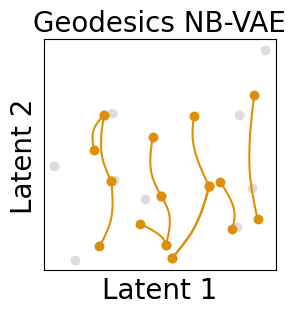

In [47]:
# Create a figure
plt.figure(figsize=(3,3))

plt.scatter(latents_vae_np[pair_pool,0], latents_vae_np[pair_pool,1], color='gainsboro')
# Plot all the pairs
for i, j in pairs:
    # Compute the geodesic connecting the two points
    c = manifold_vae.connecting_geodesic(latents_vae[i], latents_vae[j], minimize_energy=False)[0]
    
    # Plot the starting and ending points
    plt.scatter(latents_vae[i][0], latents_vae[i][1], color=palette[1], label=f'Point {i}' if (i,j) == pairs[0] else "")
    plt.scatter(latents_vae[j][0], latents_vae[j][1], color=palette[1], label=f'Point {j}' if (i,j) == pairs[0] else "")
    
    # Compute the curve points
    curve = c(torch.linspace(0, 1, 100))

    c.plot(color=palette[1])
# Show the plot
# Remove x and y tick labels and ticks
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('Geodesics NB-VAE', fontsize=20)  # Optionally change the title
plt.savefig('paths_nbvae.svg', format='svg')
plt.show()

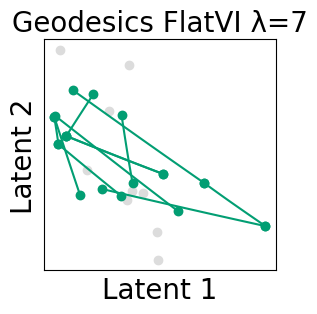

In [48]:
# Create a figure
plt.figure(figsize=(3,3))

plt.scatter(latents_flatvi_np[pair_pool,0], latents_flatvi_np[pair_pool,1], color='gainsboro')
# Plot all the pairs
for i, j in pairs:
    # Compute the geodesic connecting the two points
    c = manifold_flatvi.connecting_geodesic(latents_flatvi[i], latents_flatvi[j], minimize_energy=True)[0]
    
    # Plot the starting and ending points
    plt.scatter(latents_flatvi[i][0], latents_flatvi[i][1], color=palette[2], label=f'Point {i}' if (i,j) == pairs[0] else "")
    plt.scatter(latents_flatvi[j][0], latents_flatvi[j][1], color=palette[2], label=f'Point {j}' if (i,j) == pairs[0] else "")
    
    # Compute the curve points
    curve = c(torch.linspace(0, 1, 10))
        
    # Show the plot
    c.plot(color=palette[2])

# Remove x and y tick labels and ticks
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('Geodesics FlatVI λ=7', fontsize=20)  # Optionally change the title
plt.savefig('paths_flatvi.svg', format='svg')
plt.show()

# Plot the curves

In [49]:
# for _ in range(200):
#     i = pair_pool[random.randint(0, max_index-1)]
#     j = pair_pool[random.randint(0, max_index-1)]
#     print(i,j)
    
#     print("VAE")
#     plt.figure(figsize=(2,2))
#     c_vae = manifold_vae.connecting_geodesic(latents_vae[i], latents_vae[j], minimize_energy=False)[0]
#     c_vae.plot()
#     plt.show()

#     print("FlatVI")
#     plt.figure(figsize=(2,2))
#     c_flatvi = manifold_flatvi.connecting_geodesic(latents_flatvi[i], latents_flatvi[j], minimize_energy=False)[0]
#     c_flatvi.plot(color="red")
#     plt.show()

# Pausa with variance and magnification factor

In [50]:
from scCFM.models.manifold.geometry_metrics import *

In [51]:
metric_vae = []
with torch.no_grad():
    for p in latents_vae:
        p = p.unsqueeze(0)
        metric = manifold_vae.metric(p, model_vae._preprocess_decoder_output(model_vae.decode(p)))
        metric_vae.append(metric)
metric_vae = torch.cat(metric_vae)

In [52]:
metric_flatvi = []
with torch.no_grad():
    for p in latents_flatvi:
        p = p.unsqueeze(0)
        metric = manifold_flatvi.metric(p, model_flatvi._preprocess_decoder_output(model_flatvi.decode(p)))
        metric_flatvi.append(metric)
metric_flatvi = torch.cat(metric_flatvi)

In [53]:
get_condition_number(metric_flatvi).mean()

tensor(51.9797)

In [54]:
get_condition_number(metric_vae).mean()

tensor(53.1006)

In [55]:
def get_magnification_factor(J):
    """Magnification factor as determinant of the metric tensor

    Args:
        J (torch.tensor): metric tensor of dimension BxDxd

    Returns:
        torch.tensor: magnification factor as the squared root of the determinant
    """
    return torch.linalg.det(J)

In [56]:
adata_latent_vae = sc.AnnData(X=latents_vae.numpy().copy())
adata_latent_vae.obsm["X_emb"] = adata_latent_vae.X.copy()
adata_latent_vae.obs["var"] = get_variance(metric_vae)
adata_latent_vae.obs["condition_number"] = get_condition_number(metric_vae)
adata_latent_vae.obs["det"] = get_magnification_factor(metric_vae)
adata_latent_vae.obs["labels"] = lab_vae

In [57]:
adata_latent_flatvi = sc.AnnData(X=latents_flatvi.numpy().copy())
adata_latent_flatvi.obsm["X_emb"] = adata_latent_flatvi.X.copy()
adata_latent_flatvi.obs["var"] = get_variance(metric_flatvi)
adata_latent_flatvi.obs["condition_number"] = get_condition_number(metric_flatvi)
adata_latent_flatvi.obs["det"] = get_magnification_factor(metric_flatvi)
adata_latent_flatvi.obs["labels"] = lab_flatvi

In [58]:
from matplotlib import rcParams

FIGSIZE = (3, 3)
rcParams["figure.figsize"] = FIGSIZE

In [59]:
palette_continuous = sns.color_palette("magma")

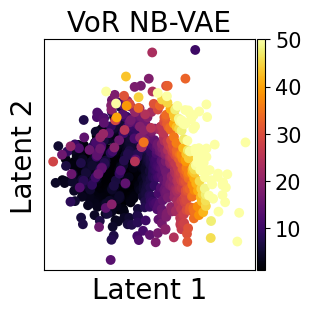

In [60]:
sc.pl.embedding(adata_latent_vae, basis="X_emb", color="var",vmin=1, vmax=50, s=200.,  title="VoR NB-VAE",show=False,
               color_map="inferno")
plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('VoR NB-VAE', fontsize=20)  # Optionally change the title
cbar = plt.gca().collections[-1].colorbar
cbar.ax.tick_params(labelsize=15)  #
plt.savefig('vor_nbvae.svg', format='svg')

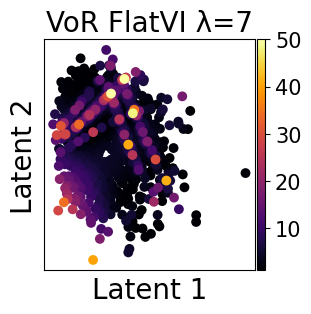

In [61]:
sc.pl.embedding(adata_latent_flatvi, basis="X_emb", color="var",vmin=1, vmax=50,s=200, title="VoR FlatVI λ=7",show=False, color_map="inferno")
plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('VoR FlatVI λ=7', fontsize=20)  # Optionally change the title
cbar = plt.gca().collections[-1].colorbar
cbar.ax.tick_params(labelsize=15)  #
plt.savefig('vor_flatvi.svg', format='svg')

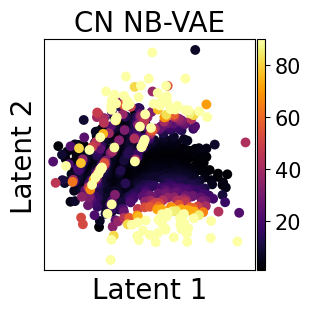

In [62]:
sc.pl.embedding(adata_latent_vae, basis="X_emb", color="condition_number",vmin=1, vmax=90, s=200, title="CN NB-VAE",show=False,color_map="inferno")
plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('CN NB-VAE', fontsize=20)  # Optionally change the title
cbar = plt.gca().collections[-1].colorbar
cbar.ax.tick_params(labelsize=15)  #
plt.savefig('cn_nb_vae.svg', format='svg')

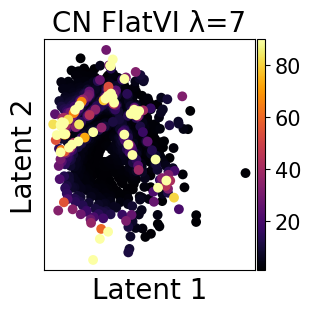

In [63]:
sc.pl.embedding(adata_latent_flatvi, basis="X_emb", color="condition_number",vmin=1, vmax=90, s=200, title="CN FlatVI λ=7",show=False,color_map="inferno")
plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('CN FlatVI λ=7', fontsize=20)  # Optionally change the title
cbar = plt.gca().collections[-1].colorbar
cbar.ax.tick_params(labelsize=15)  #
plt.savefig('cn_flatvi.svg', format='svg')

# Plot labels 

In [64]:
colorblind_palette = sns.color_palette("colorblind", n_colors=3)

In [65]:
adata_latent_flatvi.obs.labels = [lab.item() for lab in adata_latent_flatvi.obs.labels]

In [66]:
adata_latent_vae.obs.labels = [lab.item() for lab in adata_latent_vae.obs.labels]

In [67]:
adata_latent_flatvi.obs.labels = adata_latent_flatvi.obs.labels.astype("category")

In [68]:
adata_latent_vae.obs.labels = adata_latent_flatvi.obs.labels.astype("category")

In [69]:
sc.pl.embedding(adata_latent_flatvi, basis="X_emb", color="labels", s=200, title="Category NB-VAE",show=False, palette=colorblind_palette)
plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('Category NB-VAE', fontsize=20)  # Optionally change the title
plt.savefig('cat_flatvi.svg', format='svg')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [70]:
sc.pl.embedding(adata_latent_vae, basis="X_emb", color="labels", s=200, title="Category NB-VAE",show=False,palette=colorblind_palette)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Category NB-VAE'}, xlabel='X_emb1', ylabel='X_emb2'>

## Quantify distorsion

In [71]:
metric_fisher_vae = []
with torch.no_grad():
    for p in latents_vae:
        p = p.unsqueeze(0)
        metric = manifold_vae.metric(p, model_vae._preprocess_decoder_output(model_vae.decode(p)), return_fisher=True)
        metric_fisher_vae.append(metric)
metric_fisher_vae = torch.cat(metric_fisher_vae)
metric_fisher_vae = metric_fisher_vae.unsqueeze(-1) * torch.eye(10).unsqueeze(0)

metric_fisher_flatvi = []
with torch.no_grad():
    for p in latents_flatvi:
        p = p.unsqueeze(0)
        metric = manifold_flatvi.metric(p, model_flatvi._preprocess_decoder_output(model_flatvi.decode(p)), return_fisher=True)
        metric_fisher_flatvi.append(metric)
metric_fisher_flatvi = torch.cat(metric_fisher_flatvi)
metric_fisher_flatvi = metric_fisher_flatvi.unsqueeze(-1) * torch.eye(10).unsqueeze(0)

In [72]:
def relaxed_distortion_measure(
    func, 
    z, 
    eta=0.2, 
    metric='identity', 
    H=None,
    dim=None,
    *args, 
    **kwargs):
    
    bs = len(z)
    z_perm = z[torch.randperm(bs)]
    if eta is not None:
        alpha = (torch.rand(bs) * (1 + 2*eta) - eta).unsqueeze(1).to(z)
        z_augmented = alpha*z + (1-alpha)*z_perm
    else:
        z_augmented = z
        
    assert H is not None
    # H (1, -1, -1)
    v = torch.randn(z.size()).to(z)
    Jv = torch.autograd.functional.jvp(
        func, z_augmented, v=v, create_graph=True)[1].reshape(
            bs, -1, 1
        )    
    TrG = torch.einsum(
        'bni, bnm, bmi -> b', Jv, H.to(z), Jv
    )

    HJv = torch.einsum(
        'bnm, bmi -> bni', H.to(z), Jv
    ).reshape(bs, -1)
    
    JTHJv = (torch.autograd.functional.vjp(
        func, z_augmented, v=HJv, create_graph=True)[1]).reshape(bs, -1)
    TrG2 = torch.sum(JTHJv**2, dim=1)
    print(TrG2.shape)
    return TrG2/TrG**2


In [73]:
dist_flatvi = relaxed_distortion_measure(model_flatvi.decode, latents_flatvi, eta=0.1, H=metric_fisher_flatvi, dim=10)

torch.Size([1000])


In [74]:
dist_vae =relaxed_distortion_measure(model_vae.decode, latents_vae, eta=0.1, H=metric_fisher_vae, dim=10)

torch.Size([1000])


In [75]:
adata_latent_flatvi.obs["distorsion"] = dist_flatvi.detach().numpy()

In [76]:
adata_latent_vae.obs["distorsion"] = dist_vae.detach().numpy()

In [77]:
sc.pl.embedding(adata_latent_flatvi, basis="X_emb", color="distorsion", vmin=0, vmax=1000, s=200)

In [78]:
sc.pl.embedding(adata_latent_vae, basis="X_emb", color="distorsion", vmin=0, vmax=1000, s=200)

## Check the Vor and MF metrics of Euclidean space 

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for sampling
x_range = (-10, 10)  # Range for x-axis
y_range = (-10, 10)  # Range for y-axis
num_points = 1000  # Number of points to sample

# Random sampling within the specified ranges
np.random.seed(1)
x_coords = np.random.uniform(x_range[0], x_range[1], num_points)
y_coords = np.random.uniform(y_range[0], y_range[1], num_points)

metric = torch.stack([torch.eye(2) for _ in range(1000)], dim=0)

In [80]:
adata_flat = sc.AnnData(X=np.stack([x_coords,y_coords], axis=1))
adata_flat.obsm["X_emb"] = adata_flat.X.copy()

In [81]:
condition_number_flat = get_condition_number(metric)
variance_flat = get_variance(metric)

In [82]:
adata_flat.obs = pd.DataFrame({"CN Euclidean space": condition_number_flat.numpy(),
                                "VoR Euclidean space": variance_flat.numpy()})

In [83]:
sc.pl.embedding(adata_flat, basis="X_emb", color="CN Euclidean space",vmin=1, vmax=10, s=200, title="CN Euclidean space",show=False,color_map="inferno")
plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('CN Euclidean space', fontsize=20)  # Optionally change the title
cbar = plt.gca().collections[-1].colorbar
cbar.ax.tick_params(labelsize=15)  #
plt.savefig('cn_euclidean.svg', format='svg')

In [84]:
sc.pl.embedding(adata_flat, basis="X_emb", color="VoR Euclidean space",vmin=1, vmax=10, s=200, title="VoR Euclidean space",show=False,color_map="inferno")
plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('VoR Euclidean space', fontsize=20)  # Optionally change the title
cbar = plt.gca().collections[-1].colorbar
cbar.ax.tick_params(labelsize=15)  #
plt.savefig('vor_euclidean.svg', format='svg')

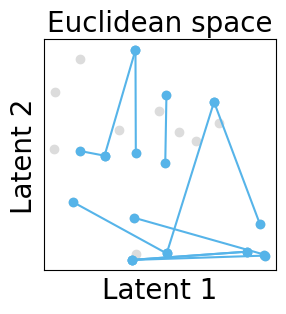

In [85]:
import matplotlib.pyplot as plt
import torch

# Create a figure
plt.figure(figsize=(3, 3))

# Scatter plot for all points
plt.scatter(x_coords[pair_pool], y_coords[pair_pool], color='gainsboro')

# Plot all the pairs
for i, j in pairs:
    # Get the starting and ending points
    point_i = (x_coords[i], y_coords[i])
    point_j = (x_coords[j], y_coords[j])

    # Plot the starting and ending points
    plt.scatter(point_i[0], point_i[1], color=palette[9], label=f'Point {i}' if (i, j) == pairs[0] else "")
    plt.scatter(point_j[0], point_j[1], color=palette[9], label=f'Point {j}' if (i, j) == pairs[0] else "")
    
    # Compute straight line points between point_i and point_j
    line_x = torch.linspace(point_i[0], point_j[0], steps=10)
    line_y = torch.linspace(point_i[1], point_j[1], steps=10)
    
    # Plot the line
    plt.plot(line_x, line_y, color=palette[9])

# Remove x and y tick labels and ticks
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

# Labels and title
plt.xlabel('Latent 1', fontsize=20)
plt.ylabel('Latent 2', fontsize=20)
plt.title('Euclidean space', fontsize=20)

# Save and show the plot
plt.savefig('paths_euclidean.svg', format='svg')
plt.show()


## Analysis of high VoR point

In [86]:
adata_latent_flatvi

AnnData object with n_obs × n_vars = 1000 × 2
    obs: 'var', 'condition_number', 'det', 'labels', 'distorsion'
    uns: 'labels_colors'
    obsm: 'X_emb'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'CN FlatVI λ=7'}, xlabel='X_emb1', ylabel='X_emb2'>,
 <Axes: title={'center': 'labels'}, xlabel='X_emb1', ylabel='X_emb2'>]

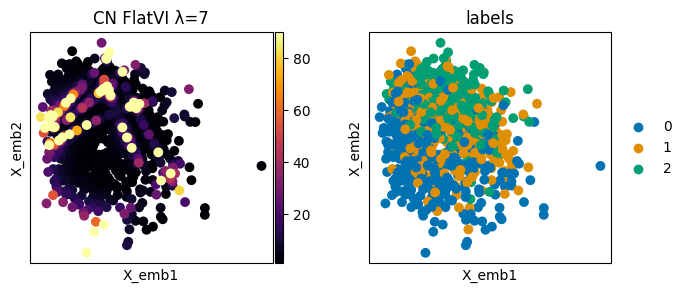

In [87]:
sc.pl.embedding(adata_latent_flatvi, basis="X_emb", color=["condition_number","labels"], vmin=1, vmax=90, s=200, title="CN FlatVI λ=7",show=False,color_map="inferno")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'CN FlatVI λ=7'}, xlabel='X_emb1', ylabel='X_emb2'>,
 <Axes: title={'center': 'labels'}, xlabel='X_emb1', ylabel='X_emb2'>]

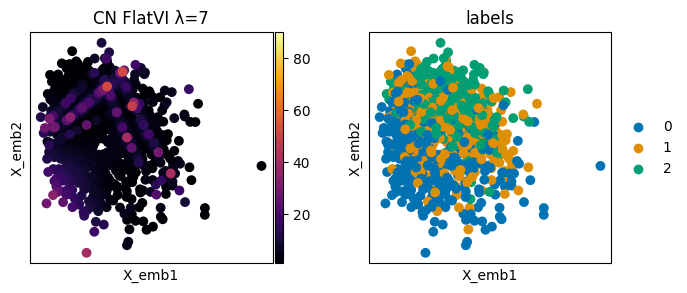

In [88]:
sc.pl.embedding(adata_latent_flatvi, basis="X_emb", color=["var","labels"], vmin=1, vmax=90, s=200, title="CN FlatVI λ=7",show=False,color_map="inferno")

In [208]:
adata = adata[adata.obs["CN FlatVI"]<300]

In [209]:
adata = adata[adata.obs["CN VAE"]<300]

In [190]:
adata.obs["VoR FlatVI"] = adata_latent_flatvi.obs["var"]
adata.obs["CN FlatVI"] = adata_latent_flatvi.obs["condition_number"]
adata.obs["VoR VAE"] = adata_latent_vae.obs["var"]
adata.obs["Label"] = adata.obs["cell_type"]
adata.obs["CN VAE"] = adata_latent_vae.obs["condition_number"]

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


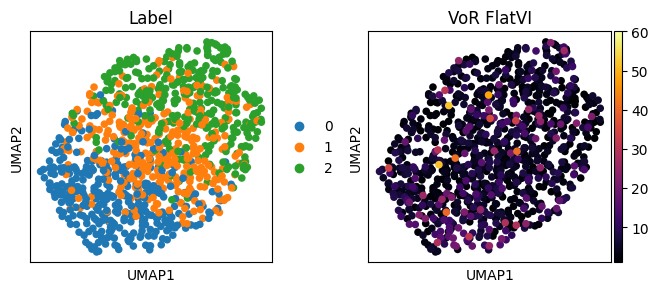

In [204]:
sc.pl.umap(adata[np.random.permutation(range(adata.shape[0]))], color=["Label","VoR FlatVI"],color_map="inferno",vmin=1, vmax=60,
           save="umap_vor_flatvi.png")

In [203]:
sc.pl.umap(adata[np.random.permutation(range(adata.shape[0]))], color=["Label","VoR VAE"],color_map="inferno",vmin=1, vmax=60,
          save="umap_vor_vae.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


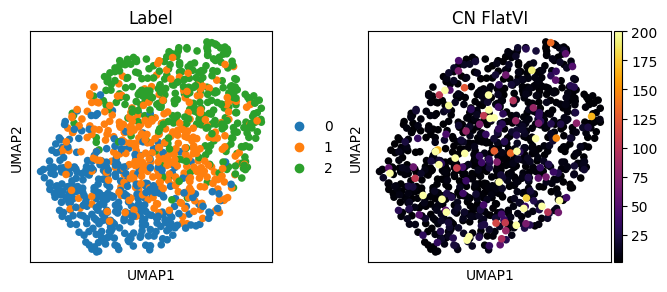

In [202]:
sc.pl.umap(adata[np.random.permutation(range(adata.shape[0]))], color=["Label","CN FlatVI"],color_map="inferno", vmin=1, vmax=200,
          save="umap_cn_flatvi.png")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


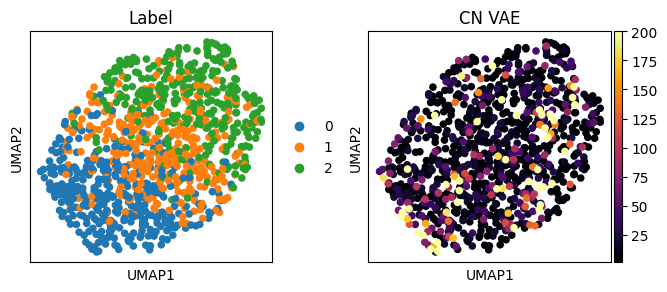

In [201]:
sc.pl.umap(adata[np.random.permutation(range(adata.shape[0]))], color=["Label","CN VAE"],color_map="inferno", vmin=1, vmax=200,
                save="umap_cn_vae.png")

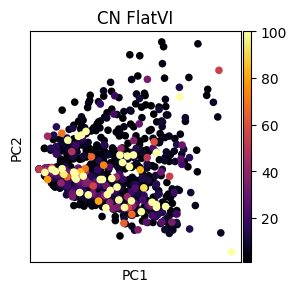

In [195]:
sc.pl.pca(adata, color="CN FlatVI",color_map="inferno", vmin=1, vmax=100)

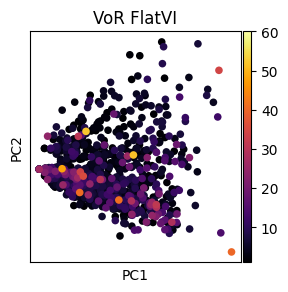

In [97]:
sc.pl.pca(adata, color="VoR FlatVI",color_map="inferno", vmin=1, vmax=60)

In [98]:
sc.pl.pca(adata, color="cell_type", color_map="inferno", vmin=1, vmax=60)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


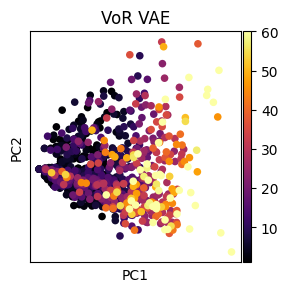

In [99]:
sc.pl.pca(adata, color="VoR VAE",color_map="inferno", vmin=1, vmax=60)

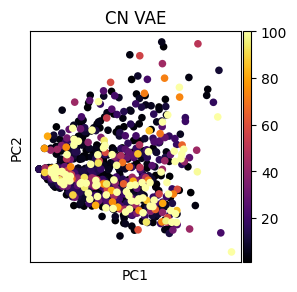

In [100]:
sc.pl.pca(adata, color="CN VAE", color_map="inferno", vmin=1, vmax=100)

In [212]:
sp.stats.pearsonr(adata.obs["VoR FlatVI"], adata.obs["CN FlatVI"])

PearsonRResult(statistic=0.5770934372396272, pvalue=7.323831404633009e-87)

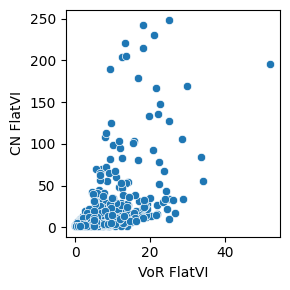

In [210]:
sns.scatterplot(data=adata.obs, x="VoR FlatVI", y="CN FlatVI")
plt.tight_layout()
plt.savefig("corr_var_cn_flatvi.png")

In [214]:
sp.stats.pearsonr(adata.obs["VoR VAE"], adata.obs["CN VAE"])

PearsonRResult(statistic=0.21493474912697677, pvalue=1.471455030097016e-11)

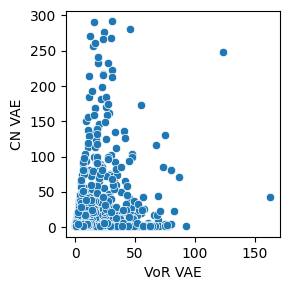

In [213]:
sns.scatterplot(data=adata.obs, x="VoR VAE", y="CN VAE")
plt.tight_layout()
plt.savefig("corr_var_cn_vae.png")

Correspond better for FlatVI, buy what are the additional characteristics of the areas?

## Finally, evaluate VoR versus likelihood

In [105]:
recon_loss_vae_list = []
recon_loss_flatvi_list = []
for i, obs in enumerate(counts):
    # Evaluate NLL
    with torch.no_grad():
        X = obs.unsqueeze(0)
        batch = {"X": X}
        library_size = X.sum(1)
        # VAE 
        decoder_output_vae, z_vae, mu_vae, logvar_vae = model_vae.forward(batch)
        decoder_output_vae = model_vae._preprocess_decoder_output(decoder_output_vae, library_size)
        recon_loss_vae = model_vae.reconstruction_loss(X, decoder_output_vae)
        recon_loss_vae_list.append(recon_loss_vae.item())

        # FlatVI
        decoder_output_flatvi, z_flatvi, mu_flatvi, logvar_flatvi = model_flatvi.forward(batch)
        decoder_output_flatvi = model_flatvi._preprocess_decoder_output(decoder_output_flatvi, library_size)
        recon_loss_flatvi = model_flatvi.reconstruction_loss(X, decoder_output_flatvi)
        recon_loss_flatvi_list.append(recon_loss_flatvi.item())       

In [106]:
len(adata)

1000

In [107]:
adata.obs["recon_loss_flatvi"] = recon_loss_flatvi_list
adata.obs["recon_loss_vae"] = recon_loss_vae_list

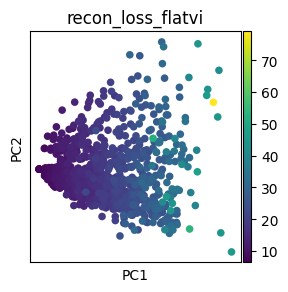

In [108]:
sc.pl.pca(adata, color="recon_loss_flatvi")

In [109]:
adata_latent_flatvi.obs["loss"] = recon_loss_flatvi_list

<Axes: title={'center': 'CN FlatVI λ=7'}, xlabel='X_emb1', ylabel='X_emb2'>

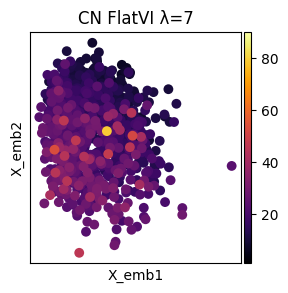

In [110]:
sc.pl.embedding(adata_latent_flatvi, basis="X_emb", color="loss", vmin=1, vmax=90, s=200, title="CN FlatVI λ=7",show=False,color_map="inferno")

**RQ 2: In the single-cell data**

In [111]:
adata.obs["size_factor"] = adata.X.sum(1)

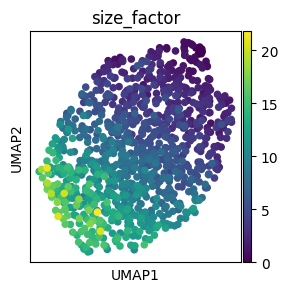

In [112]:
sc.pl.umap(adata, color="size_factor")

**RQ 3: What's up with cells with high VoR**

Is it the max?

In [113]:
adata_high_vor_flatvi = adata[adata.obs['VoR FlatVI']>50]

In [114]:
adata_high_vor_flatvi.layers["X_counts"]

ArrayView([[ 5.,  0.,  1.,  0.,  0.,  0.,  3.,  4.,  0.,  0.],
           [17.,  0.,  0.,  1.,  0.,  3., 14.,  2.,  1.,  2.]],
          dtype=float32)

In [115]:
adata_low_vor_flatvi = adata[adata.obs['VoR FlatVI']<3]

In [116]:
adata_low_vor_flatvi.layers["X_counts"].max(1)

array([  7.,   5.,   2.,   4.,   3.,   6.,   9.,   2.,  10.,   2.,   6.,
        10.,   1.,   0.,   5.,   3.,   6.,  18.,   3.,  10.,   4.,   5.,
         4.,   1.,  13.,   3.,  11.,   3.,   3.,  12.,   8.,   1.,  15.,
         9.,   2.,   8.,   9.,   6.,  16.,  65.,   9.,   6.,  16.,   2.,
         3.,   3.,  12.,  12.,   6.,   4.,  13.,  31.,   3.,   2.,   3.,
         9.,   4.,   6.,   5.,   9.,   4.,   3.,   3.,  14.,   2.,   4.,
         1.,   2.,   6.,  29.,  11.,  12.,   3.,   7.,   3.,   2.,   4.,
         4.,  37.,  15.,   2.,  21.,  13.,  13.,   5.,   3.,   6.,   9.,
         3.,   6.,  19.,  12.,   3.,   1.,   1.,   5.,   1.,   5.,   1.,
        28.,   1.,   6.,  21.,  27.,   3.,   7.,   4.,   3.,   3.,  71.,
        22.,  13.,  15.,  89.,   2.,   5.,   2.,   4.,   3.,   3.,   2.,
         2.,   7.,  23.,   2.,  13.,   3.,   2.,   5.,   2.,   5.,   2.,
        18.,   2.,   4.,  28.,   2.,  14.,   4.,   8.,   2.,  12.,   9.,
         9.,   2.,  12.,   2.,  15.,   4.,   2.,  1

In [117]:
adata.obs["max"] = adata.layers["X_counts"].max(1)

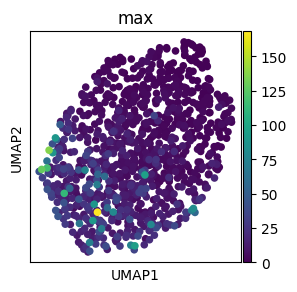

In [118]:
sc.pl.umap(adata, color="max")

Is it the sparsity?

In [119]:
adata.obs["sparsity"] = (adata.layers["X_counts"]==0).sum(1)

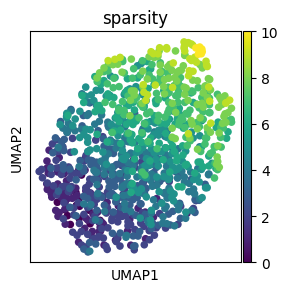

In [120]:
sc.pl.umap(adata, color="sparsity")

**RQ 4: Neighbors**

In [121]:
from scipy.spatial import distance_matrix

In [122]:
# dist_matrix = distance_matrix(adata.X, adata.X)
dist_matrix = distance_matrix(adata.obsm["X_pca"][:,:2], adata.obsm["X_pca"][:,:2])
# dist_matrix = distance_matrix(adata_latent_flatvi.X, adata_latent_flatvi.X)

In [123]:
n_neigh = 1
neigh = dist_matrix.argsort(1)[:,:(n_neigh+1)]
neighborhood_composition = np.array(adata.obs.cell_type)[neigh]

In [124]:
neighborhood_composition = neighborhood_composition != neighborhood_composition[:,0][:,np.newaxis]
neighborhood_composition = neighborhood_composition[:,1:]

In [125]:
# neighborhood_composition != neighborhood_composition[:,0][:,np.newaxis]

In [126]:
different_from_main = neighborhood_composition.sum(1)/n_neigh

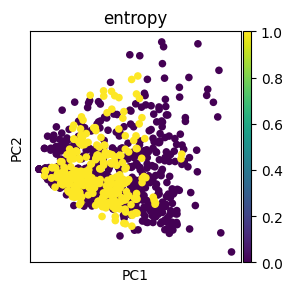

In [127]:
adata.obs["entropy"] = different_from_main
sc.pl.pca(adata, color="entropy")

<Axes: xlabel='VoR VAE', ylabel='entropy'>

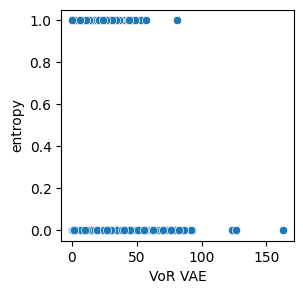

In [128]:
sns.scatterplot(adata.obs, x="VoR VAE", y="entropy")

<Axes: xlabel='VoR FlatVI', ylabel='entropy'>

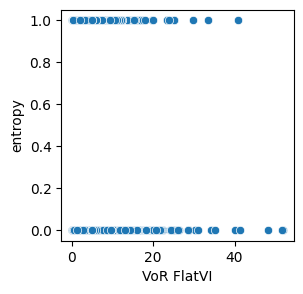

In [129]:
sns.scatterplot(adata.obs, x="VoR FlatVI", y="entropy")

<Axes: xlabel='CN VAE', ylabel='entropy'>

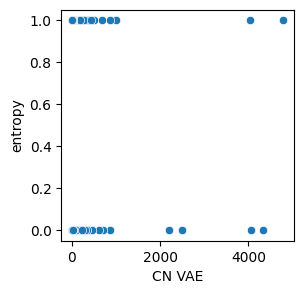

In [130]:
sns.scatterplot(adata.obs, x="CN VAE", y="entropy")

<Axes: xlabel='CN FlatVI', ylabel='entropy'>

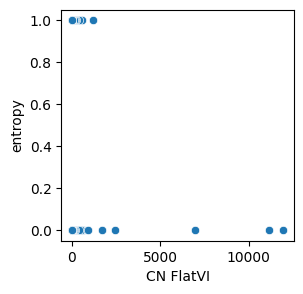

In [131]:
sns.scatterplot(adata.obs, x="CN FlatVI", y="entropy")

In [132]:
# sns.scatterplot(adata.obs, x="cell_type", y="CN FlatVI")

In [133]:
# sns.scatterplot(adata.obs, x="cell_type", y="VoR FlatVI")

In [134]:
# sp.stats.pearsonr(adata.obs["cell_type"], adata.obs["VoR FlatVI"])

In [135]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


**RQ 5: Run Knn**

In [136]:
from sklearn.cluster import KMeans

In [137]:
adata.X

array([[0.       , 0.       , 0.       , ..., 0.       , 1.9459102,
        1.7917595],
       [0.       , 0.6931472, 0.       , ..., 1.0986123, 0.       ,
        0.       ],
       [0.6931472, 0.6931472, 0.       , ..., 0.       , 1.3862944,
        1.0986123],
       ...,
       [0.       , 1.3862944, 4.2904596, ..., 0.       , 0.6931472,
        1.0986123],
       [0.       , 0.       , 0.       , ..., 0.6931472, 0.       ,
        0.       ],
       [0.       , 0.6931472, 0.       , ..., 0.       , 2.7725887,
        0.6931472]], dtype=float32)

In [138]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(adata.X)

In [139]:
kmeans_pred = kmeans.predict(adata.X)

In [140]:
adata.obs["k_means"] = kmeans_pred

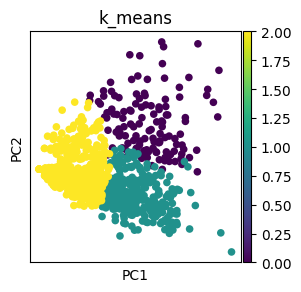

In [141]:
sc.pl.pca(adata, color="k_means")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


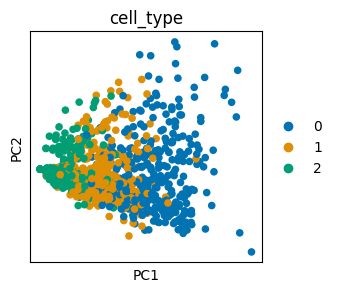

In [142]:
sc.pl.pca(adata, color="cell_type")

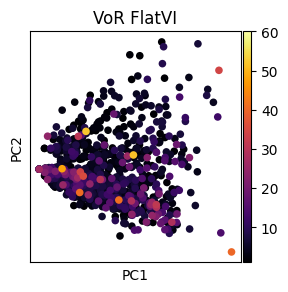

In [143]:
sc.pl.pca(adata, color="VoR FlatVI",color_map="inferno", vmin=1, vmax=60)

## Train knn sklearn

In [144]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'adata' is your AnnData object
X = adata.obsm["X_pca"][:,:2]  # Feature matrix
y = adata.obs["cell_type"]  # Class labels

# Ensure y is in a numeric or categorical format if necessary
if not y.dtype.name == 'category':
    y = y.astype('category')

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)  # You can adjust the number of neighbors
knn.fit(X, y)

# Make predictions on the test set
y_pred = knn.predict(X)

In [145]:
adata.obs["Is misclassified"] = y_pred != y
adata.obs["Is misclassified"] = adata.obs["Is misclassified"].astype("category")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


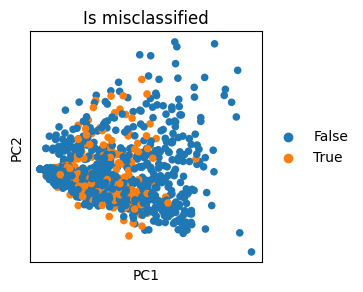

In [146]:
sc.pl.pca(adata, color="Is misclassified")

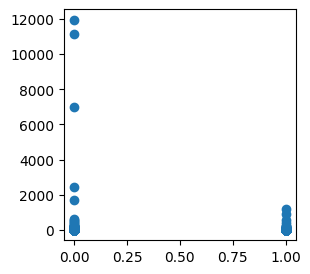

In [147]:
plt.scatter(adata.obs["Is misclassified"], adata.obs["CN FlatVI"])

## Evaluate the if paths are less straight for high VoR cells

In [148]:
cells_high_vor = np.where(adata.obs["VoR FlatVI"]>40)[0]
cells_high_vor_pairs = []
for cell in cells_high_vor: 
    for _ in range(5):
        cells_high_vor_pairs.append((cell, np.random.choice(range(len(latents_flatvi_np)))))

In [149]:
cells_high_vor

array([265, 402, 451, 492, 520, 900])

In [150]:
# for (i,j) in cells_high_vor_pairs:
#     print("FlatVI")
#     plt.figure(figsize=(2,2))
#     c_flatvi = manifold_flatvi.connecting_geodesic(latents_flatvi[i], latents_flatvi[j], minimize_energy=False)[0]
#     c_flatvi.plot(color="red")
#     plt.show()

FlatVI
265 894


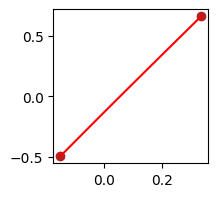

FlatVI
265 686


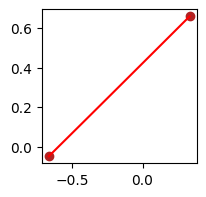

FlatVI
265 403


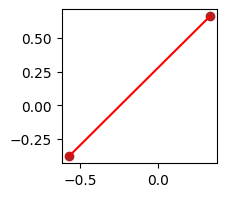

FlatVI
265 207


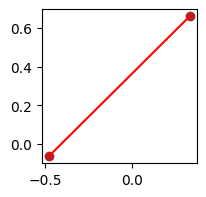

FlatVI
265 698


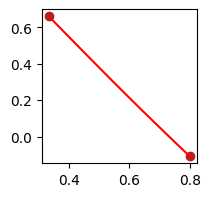

FlatVI
402 478


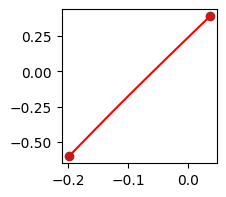

FlatVI
402 188


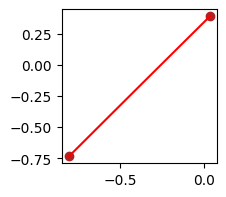

FlatVI
402 375


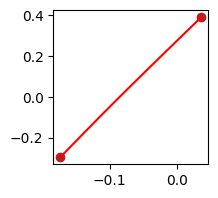

FlatVI
402 753


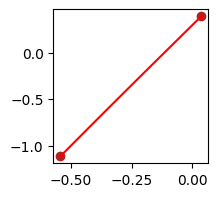

FlatVI
402 252


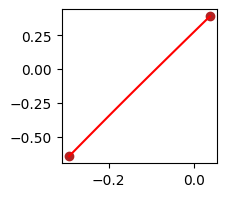

FlatVI
451 309


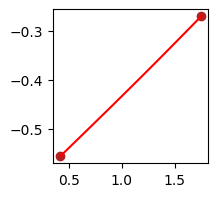

FlatVI
451 397


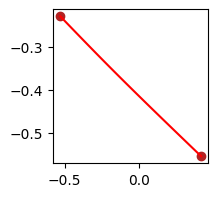

FlatVI
451 670


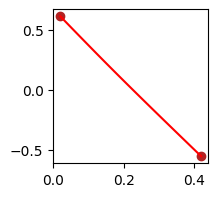

FlatVI
451 28


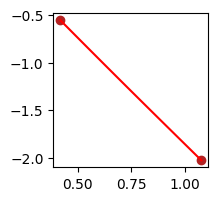

FlatVI
451 386


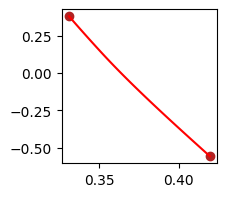

FlatVI
492 587


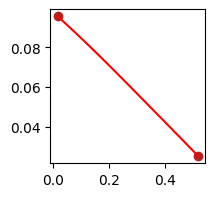

FlatVI
492 476


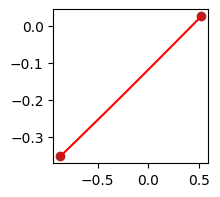

FlatVI
492 43


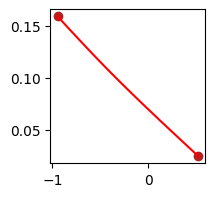

FlatVI
492 541


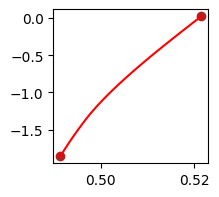

FlatVI
492 986


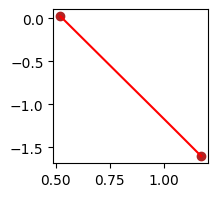

FlatVI
520 207


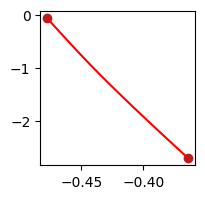

FlatVI
520 303


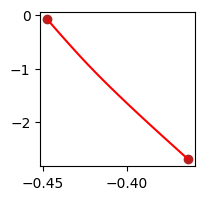

FlatVI
520 290


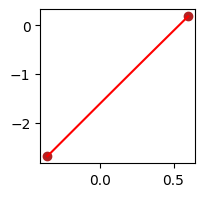

FlatVI
520 668


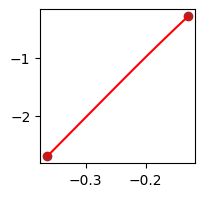

FlatVI
520 137


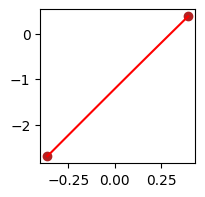

FlatVI
900 237


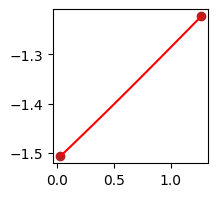

FlatVI
900 820


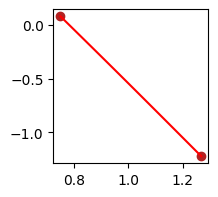

FlatVI
900 792


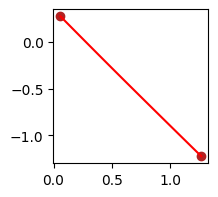

FlatVI
900 72


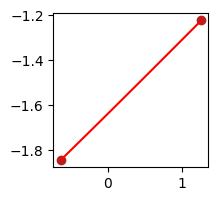

FlatVI
900 765


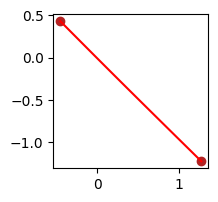

In [151]:
for (i, j) in cells_high_vor_pairs:
    print("FlatVI")
    print(i,j)
    plt.figure(figsize=(2, 2))
    
    # Plot the connecting geodesic
    c_flatvi = manifold_flatvi.connecting_geodesic(latents_flatvi[i], latents_flatvi[j], minimize_energy=False)[0]
    c_flatvi.plot(color="red")
    
    # Add markers for the endpoints
    plt.scatter(*latents_flatvi[i], color="firebrick", marker="o", label="Start")  # Starting point
    plt.scatter(*latents_flatvi[j], color="firebrick", marker="o", label="End")   # Ending point
    
    plt.show()

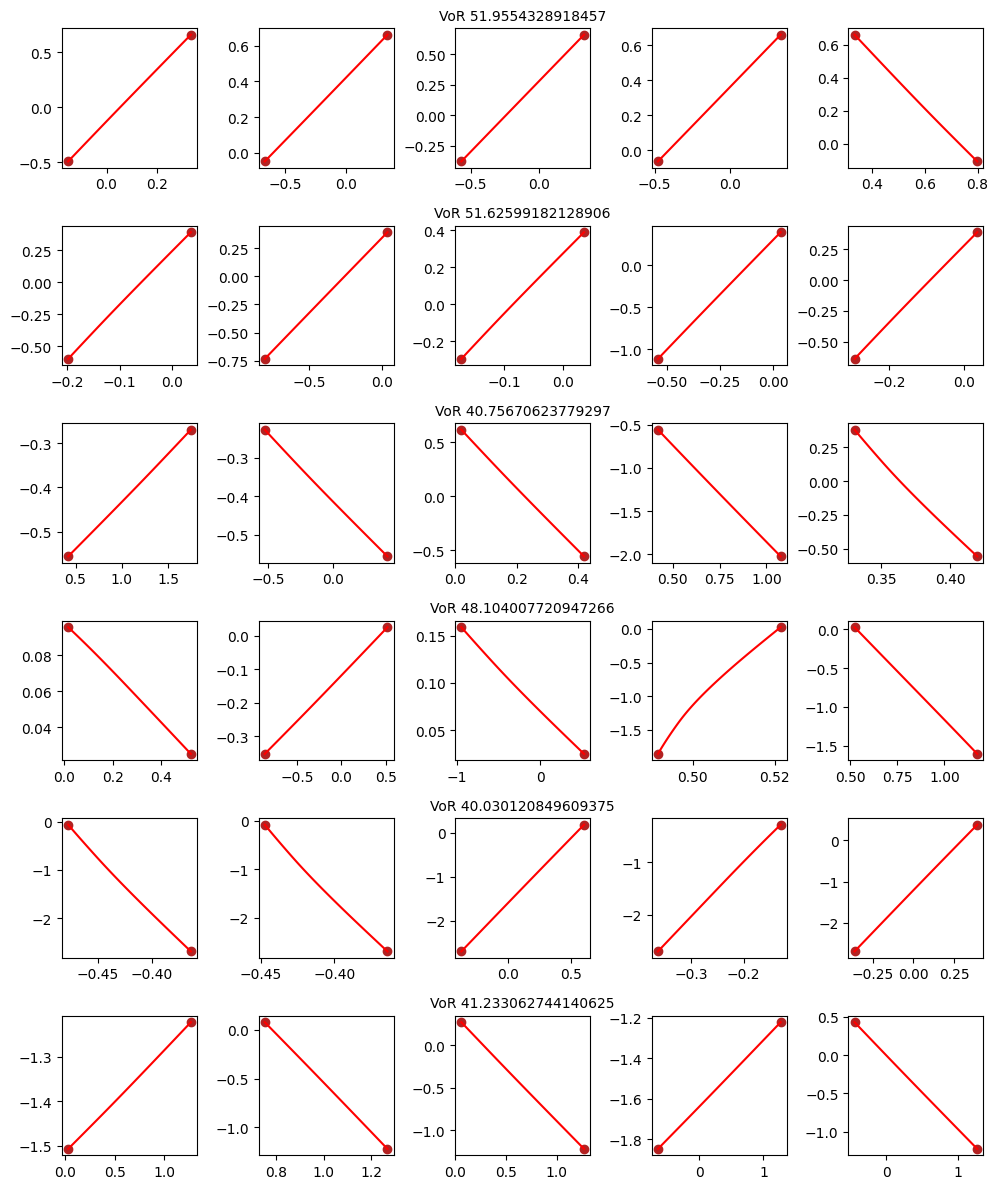

In [152]:
import matplotlib.pyplot as plt

# Create a 6x5 grid with smaller plot sizes
fig, axes = plt.subplots(6, 5, figsize=(10, 12))  # Adjusted figure size for smaller plots
axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

for idx, (i, j) in enumerate(cells_high_vor_pairs):
    if idx >= 30:  # Limit to 30 pairs to fit the grid
        break
    
    ax = axes[idx]
    
    # Plot the connecting geodesic
    c_flatvi = manifold_flatvi.connecting_geodesic(latents_flatvi[i], latents_flatvi[j], minimize_energy=False)[0]
    c_flatvi.plot(ax=ax, color="red")
    
    # Add markers for the endpoints
    ax.scatter(*latents_flatvi[i], color="firebrick", marker="o")  # Starting point
    ax.scatter(*latents_flatvi[j], color="firebrick", marker="o")  # Ending point
    
    # Annotate only the middle plot in each row (index 2, 7, 12, 17, 22, 27)
    if idx % 5 == 2:  # The middle plot in a 5-column row
        ax.set_title(f"VoR {adata.obs['VoR FlatVI'][i]}", fontsize=10)
    
    # ax.axis('off')  # Turn off axis labels for a cleaner look

# Hide any unused subplots if pairs < 30
for idx in range(len(cells_high_vor_pairs), len(axes)):
    axes[idx].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("paths_high_vor.png", format="png")
plt.show()

## Check from the classes 

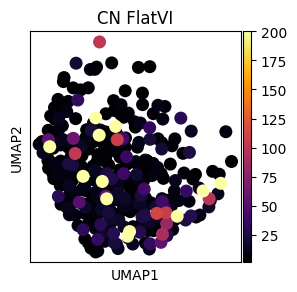

In [153]:
sc.pl.umap(adata[adata.obs.cell_type==0], color="CN FlatVI", color_map="inferno", vmin=1, vmax=200)

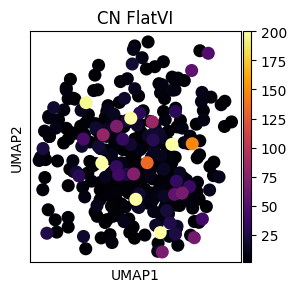

In [154]:
sc.pl.umap(adata[adata.obs.cell_type==1], color="CN FlatVI", color_map="inferno", vmin=1, vmax=200)

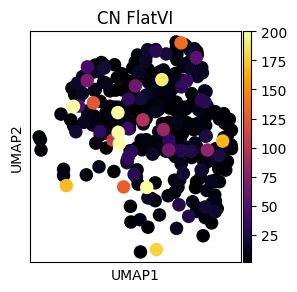

In [155]:
sc.pl.umap(adata[adata.obs.cell_type==2], color="CN FlatVI", color_map="inferno", vmin=1, vmax=200)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


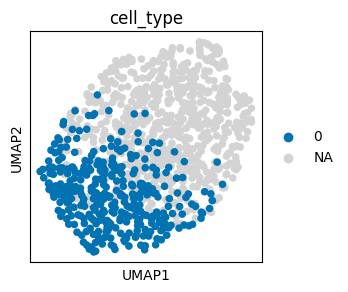

In [156]:
sc.pl.umap(adata, color=["cell_type"], groups=[0])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


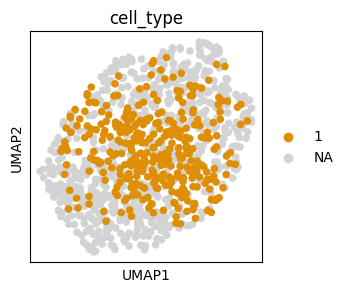

In [157]:
sc.pl.umap(adata, color=["cell_type"], groups=[1])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


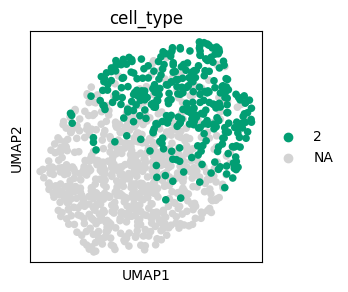

In [158]:
sc.pl.umap(adata, color=["cell_type"], groups=[2])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


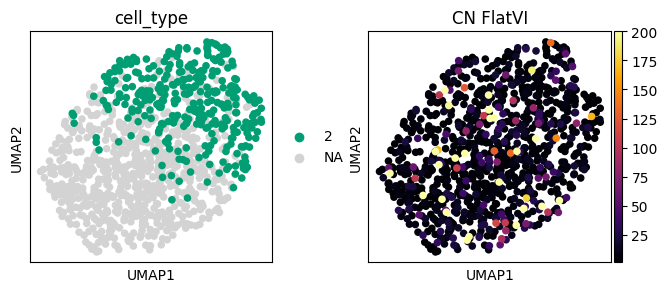

In [159]:
sc.pl.umap(adata, color=["cell_type", "CN FlatVI"], groups=[2],color_map="inferno", vmin=1, vmax=200)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


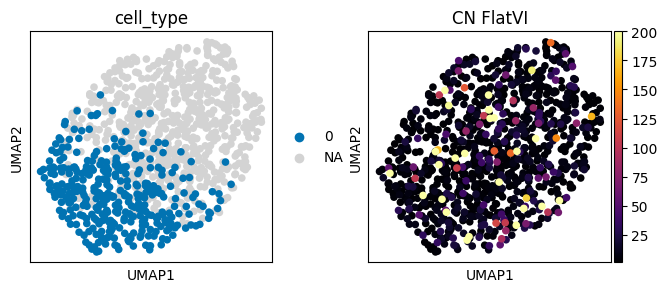

In [160]:
sc.pl.umap(adata, color=["cell_type", "CN FlatVI"], groups=[0],color_map="inferno", vmin=1, vmax=200)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


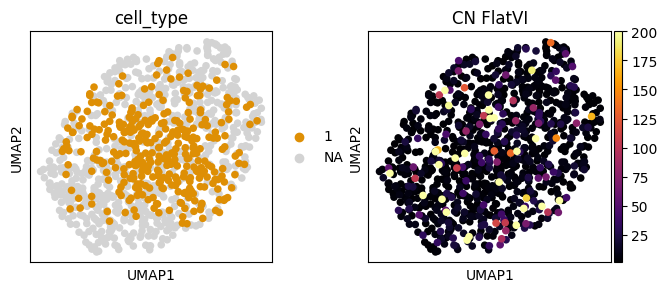

In [161]:
sc.pl.umap(adata, color=["cell_type", "CN FlatVI"], groups=[1],color_map="inferno", vmin=1, vmax=200)

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

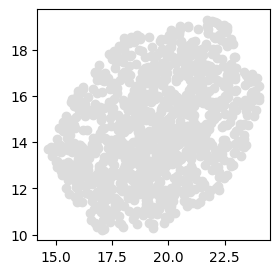

In [225]:
import matplotlib.pyplot as plt

# Extract UMAP coordinates
umap_coords = adata.obsm["X_umap"]
x = umap_coords[:, 0]
y = umap_coords[:, 1]

plt.scatter(x,y, color="gainsboro")
plt.scatter(x[adata.obs["cell_type"]==0],y[adata.obs["cell_type"]==0], color=adata.obs["CN FlatVI"])

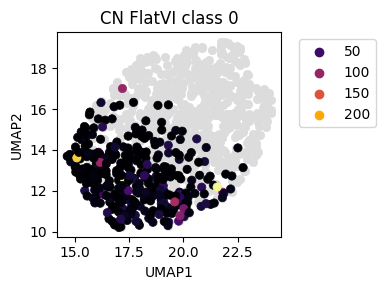

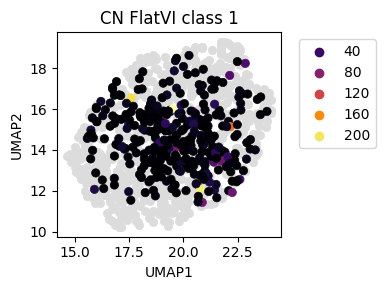

In [256]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns

mask_0 = adata.obs["cell_type"] == 0
mask_1 = adata.obs["cell_type"] == 1
mask_2= adata.obs["cell_type"] == 2

to_plot = {"x":umap_coords[:, 0], 
          "y":umap_coords[:, 1],
          "CN FlatVI": adata.obs["CN FlatVI"]}

to_plot_class0 = {"x":umap_coords[:, 0][mask_0], 
          "y":umap_coords[:, 1][mask_0],
          "CN FlatVI": adata.obs["CN FlatVI"][mask_0]}

to_plot_class1 = {"x":umap_coords[:, 0][mask_1], 
          "y":umap_coords[:, 1][mask_1],
          "CN FlatVI": adata.obs["CN FlatVI"][mask_1]}

to_plot_class2 = {"x":umap_coords[:, 0][mask_2], 
          "y":umap_coords[:, 1][mask_2],
          "CN FlatVI": adata.obs["CN FlatVI"][mask_2]}

plt.figure(figsize=(4,3))
sns.scatterplot(to_plot, x="x", y="y", color="gainsboro", edgecolor=None)
sns.scatterplot(to_plot_class0, x="x", y="y", hue="CN FlatVI", palette="inferno",edgecolor=None)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("CN FlatVI class 0")
plt.tight_layout()
plt.savefig("umap_cn_flatvi_0.png")
plt.show()

plt.figure(figsize=(4,3))
sns.scatterplot(to_plot, x="x", y="y", color="gainsboro", edgecolor=None)
sns.scatterplot(to_plot_class1, x="x", y="y", hue="CN FlatVI", palette="inferno",edgecolor=None)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("CN FlatVI class 1")
plt.tight_layout()
plt.savefig("umap_cn_flatvi_1.png")
plt.show()

plt.figure(figsize=(4,3))
sns.scatterplot(to_plot, x="x", y="y", color="gainsboro", edgecolor=None)
sns.scatterplot(to_plot_class2, x="x", y="y", hue="CN FlatVI", palette="inferno",edgecolor=None)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("CN FlatVI class 2")
plt.tight_layout()
plt.savefig("umap_cn_flatvi_2.png")
plt.show()